# Analyza liekov podla skupiny ATC1 
## Otazky:
* Ktore skupiny liekov sa najviac spotrebuvaju ?
* Ako sa meni spotreba podla jednotlivych kategorii ?
* Ako to suvisi s pandemiou ?

In [46]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%run tables.py

In [47]:
# Creating: detailed_table[year] 

detailed_tables = {}
for year in range(2015,2020):
    detailed_tables[year] = import_table('detailed',year).groupby('ATC1_popis').sum().sort_values(by='Počet balení',ascending=False)
    del detailed_tables[year]['ROK SPRAC']
    detailed_tables[year]['CENA'] =  detailed_tables[year]['Úhrada_SPOLU'] / detailed_tables[year]['Počet balení']
display(2019)
display(detailed_tables[2019].head())

2019

,Počet balení,Úhrada_ZP,Úhrada_PAC,Úhrada_SPOLU,CENA
ATC1_popis,,,,,
Kardiovaskulárny systém,3.009478e+07,1.366732e+08,73614509.50,2.102878e+08,6.987516
Nervový systém,2.528963e+07,1.029034e+08,58926530.22,1.618300e+08,6.399066
Tráviaci trakt a metabolizmus,2.003817e+07,1.562717e+08,76696058.77,2.329677e+08,11.626196
Respiračný systém,1.780014e+07,5.968704e+07,73856187.61,1.335432e+08,7.502369
Krv a krvotvorné orgány,1.367591e+07,2.253825e+08,13245441.18,2.386280e+08,17.448775


In [48]:
# Creating: detailed_table[2020] 

temp = import_table('detailed',2020) 
detailed_tables[2020] = temp['Q1'].groupby('ATC1_popis').sum().sort_index()
#display(temp['Q1'].groupby('ATC1_popis').sum().sort_index().shape)
for i in range(2,4):
    #display(temp[f'Q{i}'].groupby('ATC1_popis').sum().sort_index().shape)
    detailed_tables[2020] =  detailed_tables[2020] + temp[f'Q{i}'].groupby('ATC1_popis').sum().sort_index()
del detailed_tables[2020]['ROK SPRAC']
detailed_tables[2020] = detailed_tables[2020].sort_values(by='Počet balení',ascending=False)
detailed_tables[2020]['Počet balení_estimated'] = detailed_tables[2020]['Počet balení']/75 * 100
display(detailed_tables[2020].head())

,Počet balení,Počet balení_estimated
ATC1_popis,,
Kardiovaskulárny systém,2.243462e+07,2.991283e+07
Nervový systém,1.941885e+07,2.589180e+07
Tráviaci trakt a metabolizmus,1.430232e+07,1.906976e+07
Respiračný systém,1.142406e+07,1.523209e+07
Rôzne,9.502924e+06,1.267056e+07


In [49]:
temp = {}
temp['ATC1_popis'] = []
for i in detailed_tables[2020].index:
    temp['ATC1_popis'] += [i]
    for j in range(2015,2021):
        if j not in temp:
            temp[j] = []
        if j ==2019 and i == '(prázdne)':
            temp[j] += [detailed_tables[j].loc['(prazdne)','Počet balení']]
        elif j == 2020:
            temp[j] += [detailed_tables[j].loc[i,'Počet balení_estimated']]
        else:
            temp[j] += [detailed_tables[j].loc[i,'Počet balení']]
detailed_tables['all'] =  pd.DataFrame(temp).set_index('ATC1_popis')
detailed_tables['all'] = detailed_tables['all'].rename(index={'Systémové hormonálne prípravky okrem pohlavných hormónov':'Hormonálne prípravky okrem pohlavných'})
display(detailed_tables['all'].head())

,2015,2016,2017,2018,2019,2020
ATC1_popis,,,,,,
Kardiovaskulárny systém,3.187437e+07,3.146644e+07,3.072354e+07,3.032789e+07,3.009478e+07,2.991283e+07
Nervový systém,2.565168e+07,2.565618e+07,2.507354e+07,2.561874e+07,2.528963e+07,2.589180e+07
Tráviaci trakt a metabolizmus,1.918639e+07,1.965176e+07,1.968389e+07,1.992195e+07,2.003817e+07,1.906976e+07
Respiračný systém,1.703448e+07,1.678311e+07,1.720150e+07,1.771564e+07,1.780014e+07,1.523209e+07
Rôzne,1.409553e+07,1.374374e+07,1.303431e+07,1.280559e+07,1.165731e+07,1.267056e+07


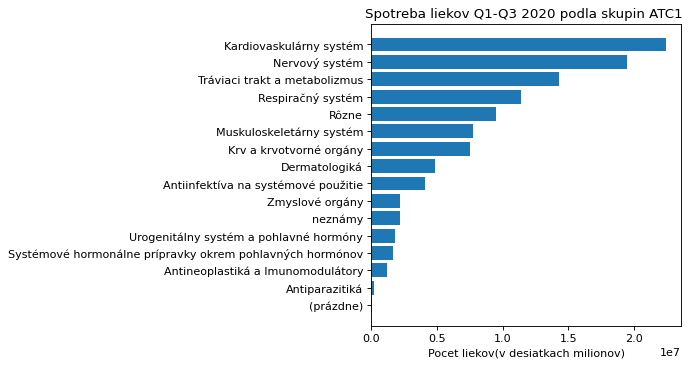

In [50]:
plt.figure(figsize=(5, 5), dpi=80)
plt.barh(y=detailed_tables[2020].sort_values(by='Počet balení',ascending=True).index,
width=detailed_tables[2020].sort_values(by='Počet balení',ascending=True)['Počet balení'])
plt.xlabel('Pocet liekov(v desiatkach milionov)')
plt.title('Spotreba liekov Q1-Q3 2020 podla skupin ATC1 ')
plt.show()

## Pozorovanie
Na grafe je vidiet ze v roku 2020 bolo najviac spotrebovanych liekov v oblastiach:
* Kardiovaskulárny systém
* Nervový systém
* Tráviaci trakt a metabolizmus
* Respiračný systém
* Rôzne
* Muskuloskeletárny systém

Dalej chceme zistit ci rastie alebo klesa spotreba liekov v tych oblastiach

In [51]:
temp = import_table('all',2019)
tab2019_Q13 = temp['Q1'].loc[:,['LIEK_popis','Počet balení_Q1']].rename(columns={'Počet balení_Q1':'Počet balení_Q1-Q3'})
for index in 'Q2','Q3':
    tab2019_Q13['Počet balení_Q1-Q3'] += temp[index][f'Počet balení_{index}']

temp = import_table('detailed',2019)
temp.drop_duplicates(subset='LIEK_popis',inplace=True)
temp = temp[['LIEK_popis','ATC1_popis']]

tab2019_Q13 = tab2019_Q13.merge(temp,on='LIEK_popis').groupby('ATC1_popis').sum().sort_values(by='Počet balení_Q1-Q3',ascending=False)
tab2019_Q13 = tab2019_Q13.rename(index={'(prazdne)':'(prázdne)'})
display(tab2019_Q13.head())

,Počet balení_Q1-Q3
ATC1_popis,
Kardiovaskulárny systém,2.232247e+07
Nervový systém,1.840355e+07
Tráviaci trakt a metabolizmus,1.452565e+07
Respiračný systém,1.256299e+07
Krv a krvotvorné orgány,1.071284e+07


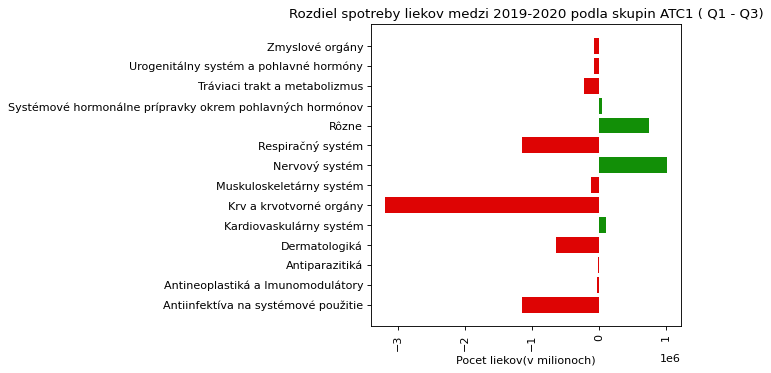

In [52]:
temp2020 = detailed_tables[2020].sort_index()
temp2019 = tab2019_Q13.sort_index()

temp2019 =  temp2019.drop(index=['neznámy',"(prázdne)"])
temp2020 =  temp2020.drop(index=['neznámy',"(prázdne)"])

color = ['#de0404' if diff < 0 else '#128f07' for diff in temp2020['Počet balení'] - temp2019['Počet balení_Q1-Q3']]

plt.figure(figsize=(5, 5), dpi=80)
plt.barh(width= temp2020['Počet balení'] - temp2019['Počet balení_Q1-Q3'] , y=temp2020.sort_index().index,color=color)
plt.xticks(rotation=90)
plt.xlabel('Pocet liekov(v milionoch)')
plt.title('Rozdiel spotreby liekov medzi 2019-2020 podla skupin ATC1 ( Q1 - Q3)')
plt.show()

## Pozorovanie
Z kategorii z ktorych najviac liekov se spotrebovali za rok 2020 zazili narast:
* Nervovy system
* Rozne

Ostatne kategorie bud stagnju alebo zazivaju znacny pokles, co je pozitivna sprava. To moze byt zapricinene zlepsujucim zivotnym standartom.

Poznamky:
* Preco ludia viac uzivaju lieky na nervovy system  ? 
* Zvysila sa spotreba vaznejsich liekov alebo menej vaznych ?
* Expandovala definicia pre kategoriu rozne ?


## Nervova sustava


In [53]:
def compare_atc2_2020(atc1,year):
    '''
    DESCRIPTION
    return a table where a certain atc1 group will be divided to its atc2 groups, where it will compare the number of used drugs in every atc2 group in     2020 and `year`
    INPUT
    atc1: string - any atc1 group 
    year: int -  2018 or 2019 
    OUTPUT
    pandas dataframe
    '''
    temp = import_table('detailed',2020)
    for i in temp:
        temp[i] = temp[i][['ATC1_popis','ATC2_popis','Počet balení']].query(f"ATC1_popis == '{atc1}'").groupby('ATC2_popis').sum()
    tab_atc2 = temp['Q1'].rename(columns={'Počet balení':2020})
    for i in 'Q2','Q3':
        tab_atc2[2020] += temp[i]['Počet balení']
    tab_atc2 = tab_atc2.sort_values(by=2020,ascending=False)
    temp = import_table('all',year)
    tab_Q13_atc2 = temp['Q1'].loc[:,['LIEK_popis','Počet balení_Q1']].rename(columns={'Počet balení_Q1':'Počet balení_Q1-Q3'})
    for index in 'Q2','Q3':
        tab_Q13_atc2['Počet balení_Q1-Q3'] += temp[index][f'Počet balení_{index}']
    temp = import_table('detailed',year)
    temp.drop_duplicates(subset='LIEK_popis',inplace=True)
    temp = temp[['LIEK_popis','ATC2_popis','ATC1_popis']]
    temp = temp.query(f'ATC1_popis == "{atc1}"')
    tab_Q13_atc2 = tab_Q13_atc2.merge(temp,on='LIEK_popis').groupby('ATC2_popis').sum().sort_values(by='Počet balení_Q1-Q3',ascending=False)
    tab_atc2[year] = tab_Q13_atc2['Počet balení_Q1-Q3']
    tab_atc2 = tab_atc2.reset_index()

    return tab_atc2

    

In [54]:
tab_compare_neural_drugs = compare_atc2_2020('Nervový systém',2019)
tab_compare_neural_drugs.iloc[4,0] = 'Ine'
display(tab_compare_neural_drugs)

,ATC2_popis,2020,2019
0,Analgetiká,7974477.098,7116060.683
1,Psycholeptiká,6060131.192,5924671.855
2,Psychoanaleptiká,3094981.021,3027177.859
3,Antiepileptiká,1090185.074,1083498.718
4,Ine,552903.699,579923.085
5,Anestetiká,324843.102,352392.596
6,Antiparkinsoniká,321326.401,319820.728


### Poznamky
* Analgetika su na zmiernenie bolesti
* Psycholeptiká su na liecbu schizofrenie a uzkosti
* Psychoanaleptiká su na zvysenie ucinnosti nervovej sustavy ( kofein, kokain ...)
* Antiepileptiká su na liecbu epilepsie
* Anestetiká su na znecitlivenie organizmu
* Antiparkinsoniká su na liecbu parkinsona

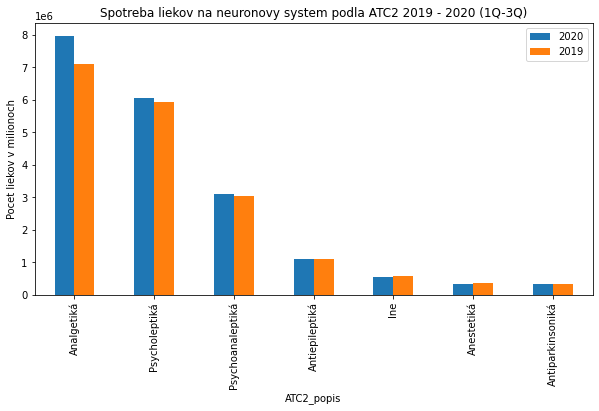

In [55]:
ax = tab_compare_neural_drugs.plot(x='ATC2_popis',y=[2020,2019], kind='bar',figsize=(10,5))
ax.set_ylabel('Pocet liekov v milionoch')
ax.set_title('Spotreba liekov na neuronovy system podla ATC2 2019 - 2020 (1Q-3Q)')
plt.show()

## Pozorovanie
Podla tabulky a grafov je zjavne ze za zvysenie spotreby liekov pre neuronovy system mozu hlavne analgetika. Dalej sa pozreme na to ako sa tieto kategorie vyvyjali od roku 2015 do 2019 (2020 nie kvoli neuplnym datam)

In [56]:
def compare_atc2_all(atc1):
    '''
    DESCRIPTION
    Very similar to compare_atc2_2020, only with the difference that we are comparing multiple years from 2015 to 2019 ( 2020 not because of incomplete     data)
    INPUT
    atc1: str - any atc1 group
    OUTPUT:
    pandas dataframe
    '''
    for year in range(2015,2020):
        temp = import_table('detailed',year)
        temp = temp.query(f"ATC1_popis == '{atc1}'")
        temp = temp[['ATC2_popis','Počet balení']]
        if year == 2015:
            neural_drugs = temp.groupby('ATC2_popis').sum().rename(columns={'Počet balení':2015}).sort_index()
        else:
            neural_drugs[year] = temp.groupby('ATC2_popis').sum()['Počet balení'].sort_index()
    neural_drugs = neural_drugs.sort_values(by=2019,ascending=False).reset_index()

    return neural_drugs

In [57]:
neural_drugs = compare_atc2_all('Nervový systém')
neural_drugs.iloc[4,0] = 'Ine'
display(neural_drugs)

,ATC2_popis,2015,2016,2017,2018,2019
0,Analgetiká,1.085115e+07,1.064193e+07,1.036591e+07,1.040837e+07,9950472.697
1,Psycholeptiká,7.718598e+06,7.754001e+06,7.468977e+06,7.739591e+06,8016420.272
2,Psychoanaleptiká,3.786101e+06,3.846344e+06,3.859802e+06,4.019187e+06,4148844.542
3,Antiepileptiká,1.552458e+06,1.653421e+06,1.634450e+06,1.642543e+06,1467449.179
4,Ine,7.514569e+05,7.736741e+05,7.717053e+05,7.913905e+05,785336.726
5,Anestetiká,5.582256e+05,5.453249e+05,5.424734e+05,5.917541e+05,487995.703
6,Antiparkinsoniká,4.336952e+05,4.414777e+05,4.302279e+05,4.259033e+05,433107.009


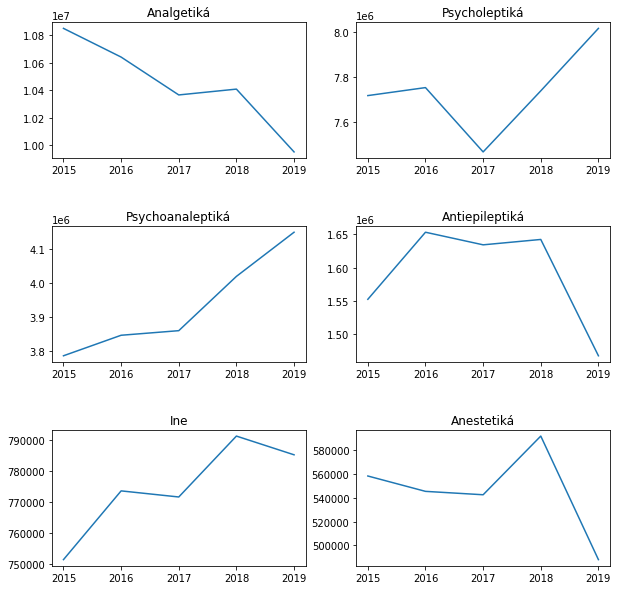

In [58]:
fig, ax = plt.subplots(3,2,figsize=(10,10))
fig.subplots_adjust(hspace =0.5)
for i in range(3):
    for j in range(2):
        ax[i,j].set_title(neural_drugs.iloc[i*2 + j,0])
        ax[i,j].plot(range(2015,2020),neural_drugs.iloc[i*2 + j,1:] )

## Pozorovanie
* Na zaklade dat vieme usudit ze zvysenie spotreby analgetik moze suvisiet s pandemiou kedze medzi rokmi 2015 - 2019 zazivala tato kategoria pokles a dalsi rok priniesol analgetikam najvyssi narast s pomedzi liekov na nervovu sustavu ( ktore mali aj navyssi narast celkovo takze pravdepodobne analgetika najviac narastli aj s pomedzi ATC2 - treba ale overit).
    * Kedze horucka sa lieci s analgetikami co je jeden s priznakov Covidu 19, tak to moze vysvetlovat narast tychto liekov pocas roku pandemie
* Psycholeptika a psychoanaleptika maju stupajuci trend od roku 2015 takze s ich narastom pravdepodobne pandemia nema vela spolocneho
### Poznamky:
* mozme sa pozriet na konkretne lieky ktore sa zvysili medzi psycholeptikami a psychoanaleptikami aby sme lepsie pochopili preco sa viac uzivaju

# Rozne

Velmi podobnu analyzu spravime aj pre atc2 skupinu rozne

In [59]:
tab_compare_various = compare_atc2_2020('Rôzne',2019)
tab_compare_various.iloc[4,0] = 'Ine'
tab_compare_various['diff'] = tab_compare_various[2020] - tab_compare_various[2019] 
tab_compare_various['diff%'] = tab_compare_various['diff'] / tab_compare_various[2019] * 100
display(tab_compare_various)

,ATC2_popis,2020,2019,diff,diff%
0,Diagnostické rádiofarmaká,8263755.793,7353259.110,910496.683,12.382219
1,Ostatné liečivá,728467.532,822035.131,-93567.599,-11.382433
2,Fytofarmaká,142709.150,146055.363,-3346.213,-2.291058
3,Ostatné pomocné a podporné prípravky,114668.031,171642.545,-56974.514,-33.193701
4,Ine,97692.800,109065.920,-11373.120,-10.427749
5,Nutričné prípravky,63794.350,64005.300,-210.950,-0.329582
6,Alergény,63535.570,60921.275,2614.295,4.291268
7,Diagnostiká,17436.244,21002.680,-3566.436,-16.980861
8,Homeopatiká,10137.830,11658.980,-1521.150,-13.047025
9,Iné rádiofarmaká,726.400,665.700,60.700,9.118221


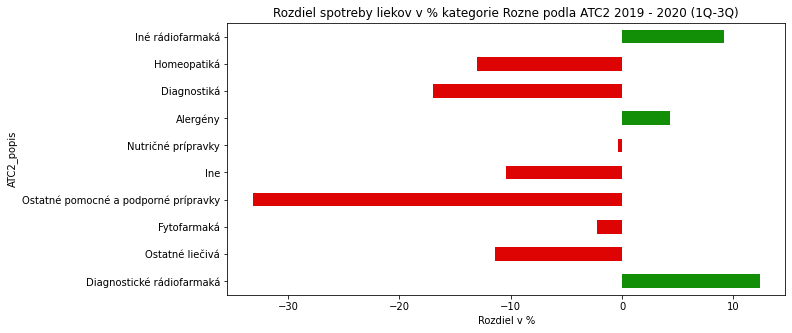

In [60]:
color = ['#de0404' if diff < 0 else '#128f07' for diff in tab_compare_various['diff%']]

ax = tab_compare_various.plot(x='ATC2_popis',y='diff%', kind='barh',figsize=(10,5),color=color,legend=False)
ax.set_xlabel('Rozdiel v %')
ax.set_title('Rozdiel spotreby liekov v % kategorie Rozne podla ATC2 2019 - 2020 (1Q-3Q)')
plt.show()

## Poznamky
* kedze pocty spotrebovanych liekov su male tak sa chcem pozriet na relativny rozdiel aby sa lepsie videli co sa deje
## Pozorovanie
* Zvysili sa diagnosticke a ine farmaka a alergeny. ine farmaka maju taku nizku spotrebu ze nam to ziadnu informaciu ale nedava
* Znizenie skumat budeme len keby nevieme co dalej, kedze znizenie aj ocakavame
* Potrebujeme zistit ci s tym mohl mat nieco pandemia pomocou skumania dlhodobeho trendu


In [61]:
various_drugs = compare_atc2_all('Rôzne')
various_drugs.iloc[4,0] = 'Ine'
display(various_drugs)

,ATC2_popis,2015,2016,2017,2018,2019
0,Diagnostické rádiofarmaká,1.080102e+07,1.074993e+07,1.019498e+07,9821441.790,9677427.170
1,Ostatné liečivá,1.688650e+06,1.461740e+06,1.387799e+06,1353895.239,1154863.933
2,Ostatné pomocné a podporné prípravky,9.397216e+05,9.513272e+05,8.710806e+05,1029531.871,247791.691
3,Fytofarmaká,3.070963e+05,2.479197e+05,2.352896e+05,233679.340,205331.603
4,Ine,1.343818e+05,1.341476e+05,1.379744e+05,149638.680,144357.470
5,Alergény,8.810770e+04,5.247433e+04,7.603646e+04,85742.119,93505.175
6,Nutričné prípravky,9.567727e+04,9.792665e+04,8.666465e+04,84223.880,86675.100
7,Diagnostiká,9.853840e+03,2.180599e+04,2.246213e+04,25668.950,30077.110
8,Homeopatiká,3.000553e+04,2.527256e+04,2.098971e+04,20752.180,16395.310
9,Iné rádiofarmaká,1.016650e+03,1.200500e+03,1.024450e+03,1012.200,882.300


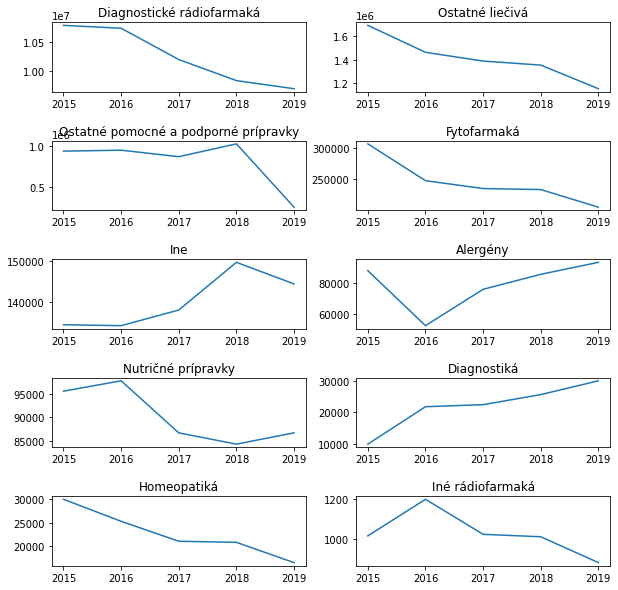

In [62]:
w,h = 2,5
fig, ax = plt.subplots(h,w,figsize=(10,10))
fig.subplots_adjust(hspace =0.7)
for i in range(h):
    for j in range(w):
        ax[i,j].set_title(various_drugs.iloc[i*2 + j,0])
        ax[i,j].plot(range(2015,2020),various_drugs.iloc[i*2 + j,1:] )

## Pozorovanie
* skupiny atc2 ktore v 2020 isli proti svojmu trendu medzi rokmi 2015-2019:
    * Diagnostika ( znizili sa )
    * Diagnosticke radiofarmaka ( zvysili sa)
* Kedze alergeny pokracuju svoj trend, mozme povedat ze zvysenie sa deje nezavisle od pandemie
* Diagnosticke radiofarmaka zmenili svoje spravanie, treba overit ci existuje dovod preco by skrz Covidu-19 sa zvysila ich spotreba alebo ci nezavisle od pandemie sa deje tento jav